## Sort-of-CLEVR Dataset

Sort-of-CLEVR dataset is a simplified version of the [CLEVR dataset](https://cs.stanford.edu/people/jcjohns/clevr/). In this simplified version the scene presented is in 2D and the questions are encoded as fixed-length binary vector to avoid the difficulty with the natural language processing of the questions.

Similar to the implementatin by [kimhc6028](https://github.com/kimhc6028/relational-networks), the dataset is composed of 10000 images with each image being associated with 20 questions (10 relational questions and 10 non-relational questions). For each image, 6 colored (red, blue, green, orange, yellow, gray) shapes (square or circle) are placed randomly in a 128x128 image.

Given a queried color, all the possible questions are as follows.

**Non-relational questions**

1. Is it a circle or a rectangle?
2. Is it on the bottom of the image?
3. Is it on the left of the image?

**Relational questions**

1. The shape of the nearest object?
2. The shape of the farthest object?
3. How many objects have the same shape?

Questions are encoded into a one-hot vector of size 11 as shown below.

*\[red, blue, green, orange, yellow, gray, relational, non-relational, question 1, question 2, question 3\]*

And the possible answer is a fixed length one-hot vector whose elements represent

*\[yes, no, rectangle, circle, 1, 2, 3, 4, 5, 6\]*

**Example**

![](figures/example.png)

So a query of "What is the shape of the nearest object to the blue object" will be represented as

\[0,1,0,0,0,0,1,0,1,0,0\]

And the answer to the query could be

\[0,0,1,0,0,0,0,0,0,0\] #rectangle

In [1]:
import time
from tqdm import *
from sort_of_clevr_generator import SortOfCLEVRGenerator
import cPickle as pickle

generator = SortOfCLEVRGenerator()
test_dataset = []
train_dataset = []
test_size = 200 #200
train_size = 9800 #9800

try:
    filename = 'sort-of-clevr.p'
    with open(filename, 'rb') as f:
        train_dataset, test_dataset = pickle.load(f)

except:

    for i in tqdm(xrange(train_size), desc='Generating Sort-of-CLEVR Training Dataset'):
        dataset = generator.generate_dataset()
        train_dataset.append(dataset)

    for i in tqdm(xrange(test_size), desc='Generating Sort-of-CLEVR Test Dataset'):
        dataset = generator.generate_dataset()
        test_dataset.append(dataset)
    
    with open("sort-of-clevr.p", 'wb') as f:
        pickle.dump((train_dataset, test_dataset), f, protocol=2)

## Preprocess Data for Training

As mentioned previously, there are 10 relational and 10 non-relational questions for each images. To make each question a training data, we will duplicate the image 20 times so there is a image paired with each single question.

In [38]:
import numpy as np
train_img = []
train_q = []
train_a = []
for img, questions, answers in test_dataset:
    img_train = img/255
    for q, a in zip(questions, answers):
        train_img += [img_train]
        train_q += [q]
        train_a += [a]
train_img = np.stack(train_img)
train_q = np.vstack(train_q)
train_a = np.vstack(train_a)

In [4]:
from sort_of_clevr_generator import SortOfCLEVRGenerator
generator = SortOfCLEVRGenerator()
img, questions, answers = generator.generate_dataset()
print img.nbytes
img.dtype

196608


dtype('float32')

## Visualize the data

Let's visualize the data to see if everything is alright

In [2]:
import matplotlib.pyplot as plt

def visualize_img(img):
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
    plt.imshow(img)
    plt.show()

def translate_question(q):
    if len(q) != 11:
        return 'Not a proper question'
    colors = ['red', 'blue', 'green', 'orange', 'yellow', 'gray']
    idx= np.argwhere(q[:6])[0][0]
    color = colors[idx]
    if q[6]:
        if q[8]:
            return 'The shape of the nearest object to the object in ' + color + ' is?' 
        elif q[9]:
            return 'The shape of the farthest object away from the object in ' + color + 'is?'
        elif q[10]:
            return 'How many objects have the same shape as the object in ' + color + '?'
    else:
        if q[8]:
            return 'Is the object in color ' + color + ' a circle or a rectangle?'
        elif q[9]:
            return 'Is the object in color ' + color + ' on the bottom of the image?'
        elif q[10]:
            return 'Is the object in color ' + color + ' on the left of the image?'
        
def translate_answer(a):
    if len(a) != 10:
        return 'Not a proper answer'
    if a[0]:
        return 'yes'
    if a[1]:
        return 'no'
    if a[2]:
        return 'rectangle'
    if a[3]:
        return 'circle'
    return np.argwhere(a[4:])[0][0] + 1

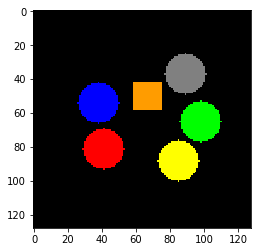

The shape of the nearest object to the object in yellow is?
circle


In [4]:
import numpy as np
idx = 10
img, q, a = train_dataset[idx]
visualize_img(img/255)
print translate_question(q[0])
print translate_answer(a[0])

## Visual Question and Answer Sort-of-CLEVR Architecture

This is the Visual QA Architecture proposed in the paper adapted for the Sort-of-CLEVR dataset

![](figures/Sort-of-CLEVRModel.png)

We will go through and implement each section of the architecture individually as specified by the authors in the paper.

## Convolutional Layer

As stated by the paper, Convolution Neural Network (CNN) was used to parse pixel inputs into a set of objects. The CNN takes images of size 128x128 and convolve them 4 convolutional layers each with 24 kernels, ReLU activation, and batch normalization. The output is 24 feature maps of size d x d. This CNN layer is implemented in the code below.

In [1]:
import keras
from keras.layers.convolutional import Conv2D

def ConvolutionNetworks(kernel_size=5, stride_size=2):
    def conv(model):
        model = Conv2D(32, (kernel_size, kernel_size), strides=(stride_size, stride_size),activation='relu',input_shape=(128, 128, 3), data_format='channels_last')(model)
        model = BatchNormalization()(model)
        model = Conv2D(64, (kernel_size, kernel_size), strides=(stride_size, stride_size),activation='relu')(model)
        model = BatchNormalization()(model)
        model = Conv2D(128, (kernel_size, kernel_size), strides=(stride_size, stride_size),activation='relu')(model)
        model = BatchNormalization()(model)
        model = Conv2D(256, (kernel_size, kernel_size), strides=(stride_size, stride_size),activation='relu')(model)
        model = BatchNormalization()(model)
        return model
    return conv

Using TensorFlow backend.


## CNN Feature Maps Post-process to Relation Network Objects

Each of the image features should constitute an object. So there are $d^2$ 24 dimensional objects in 24 feature maps of d x d dimension. According to the authors, each objects are tagged with a coordinate from a range (-1, 1) for each of the x- and y-coordinates to indicate its relative spatial position. Furthermore, the authors stated that the existence and meaning of an object-object relation should be question dependent. So they proposed that the  $g_{\theta}$ should be conditioned on the question. Modifying the Relation Networks from 

$$\text{RN}(O) = f_{\theta} (\sum_{i,j}{g_{\theta}(o_i,o_j)})$$

to

$$\text{RN}(O) = f_{\theta} (\sum_{i,j}{g_{\theta}(o_i,o_j,q)})$$

The $q$ here is simply the question encoding that we have described in the dataset.

In [3]:
import numpy as np
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Concatenate, Add
from keras.layers.normalization import BatchNormalization

def slicer(x_loc, y_loc):
    def func(x):
        return x[:,:,x_loc, y_loc]
    return Lambda(func)

def object_tagging(o, i, d):
    coor = K.variable(value=[float(int(i/d))/d*2-1, float((i%d))/d*2-1])
    coor = K.expand_dims(coor, axis=0)
    batch_size = K.shape(o)[0]
    coor = K.tile(coor, [batch_size, 1])
    coor = Input(tensor=coor)
    o = Concatenate()([coor, o])
    return o
    
def compute_relations(objects, question):
    relations = []
    #objects are tagged CNN output that has the format of (batch_size, 24+2(tagging), d, d)
    d = K.int_shape(objects)[2]
    for i in xrange(d*d):
        o_i = slicer(int(i / d), int(i % d))(objects)
#         o_i = object_tagging(o_i, i, d)
        for j in xrange(d*d):
            o_j = slicer(int(j / d), int(j % d))(objects)
#             o_j = object_tagging(o_j, j, d)
            relations.append(Concatenate()([o_i, o_j, question]))
    return relations

## Baseline Model

In this baseline model, the Relation Network architecture is simply replaced with three layer Dense layer consisting of 256, 256 (50% drop out), and 29 units. The convolutional layer remains the same.

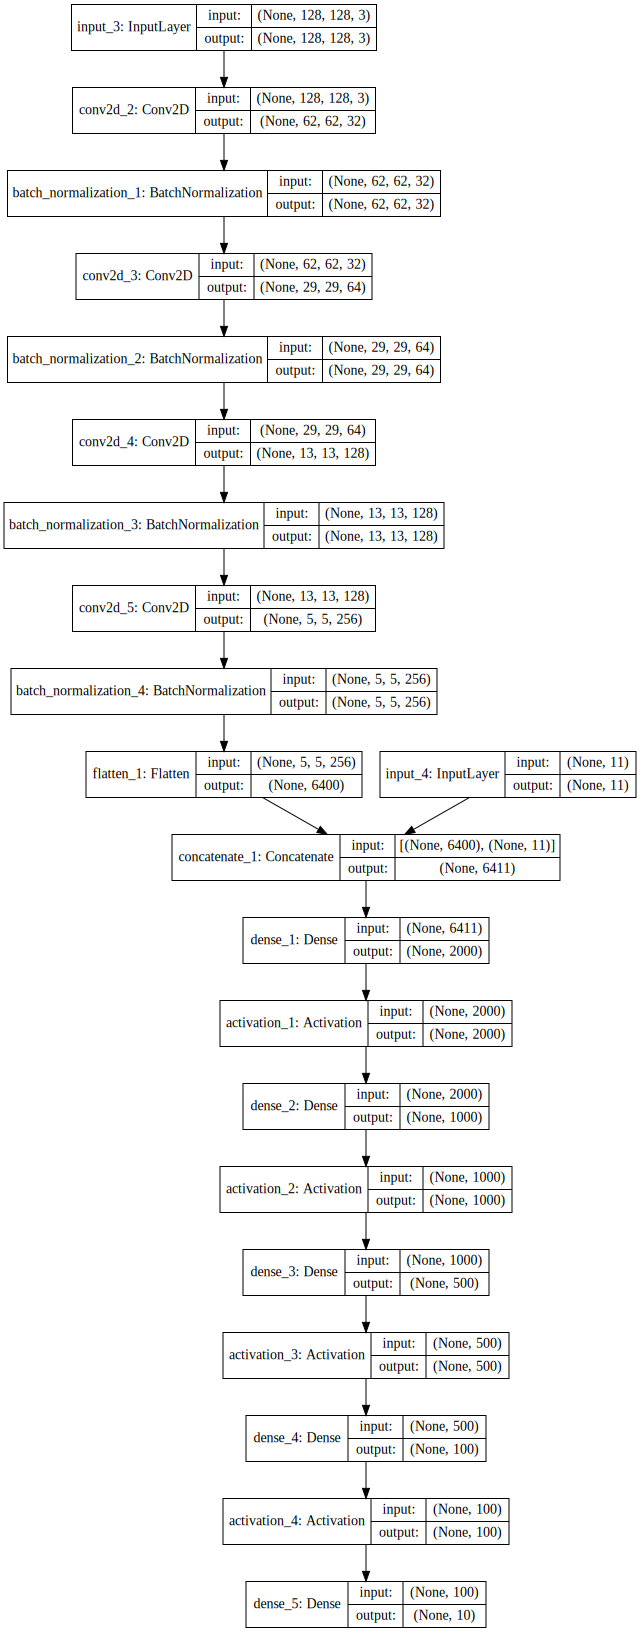

In [4]:
from keras.models import Model
from keras.layers import Input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def f_theta():
    def f(model):
        model = Dense(2000)(model)
        model = Activation('relu')(model)
        model = Dense(1000)(model)
        model = Activation('relu')(model)
#         model = Dropout(0.5)(model)
        model = Dense(500)(model)
        model = Activation('relu')(model)
        model = Dense(100)(model)
        model = Activation('relu')(model)
        return model
    return f

baseline_scene = Input((128, 128, 3))
baseline_question = Input((11,))
baseline_conv = ConvolutionNetworks()(baseline_scene)
baseline_conv = Flatten()(baseline_conv)
baseline_conv = Concatenate()([baseline_conv, baseline_question])
baseline_output = f_theta()(baseline_conv) 
baseline_output = Dense(10, activation='softmax')(baseline_output)
BaseLineModel = Model(inputs=[baseline_scene, baseline_question], outputs=baseline_output)
SVG(model_to_dot(BaseLineModel, show_shapes=True).create(prog='dot', format='svg'))

## Visual QA Sort-of-CLEVR Model

In the Visual QA Sort-of-CLEVR Model the Relation Layer is defined as: 

$$\text{RN}(O) = f_{\theta} (\sum_{i,j}{g_{\theta}(o_i,o_j,q)})$$

The $f_{\theta}$ and $g_{\theta}$ functions are layers of densely connected layers. As described by the authors, the $f_{\theta}$ function consists of three layer Dense layer consisting of 256, 256 (50% drop out), and 29 units. The convolutional layer remains the same, while the $g_{\theta}$ consists of four layers consisting of 256 units each layer with ReLU activation.


In [6]:
from keras.utils import plot_model

def g_theta(h_unit=2000, layers=4):
    def f(model):
        for n in xrange(layers):
            model = Dense(h_unit)(model)
            model = Activation('relu')(model)
        return model
    return f

def RelationNetworks(objects, question):
    relations = compute_relations(objects,question)
    for i, r in enumerate(relations):
        relations[i] = g_theta()(r)
    combined_relation = Add()(relations)
    f_out = f_theta()(combined_relation)
    return f_out

def build_tag(conv):
    d = K.int_shape(conv)[2]
    tag = np.zeros((d,d,2))
    for i in xrange(d):
        for j in xrange(d):
            tag[i,j,0] = float(int(i%d))/(d-1)*2-1
            tag[i,j,1] = float(int(j%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag, axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag, [batch_size,1,1,1])
    return Input(tensor=tag)

In [ ]:
visual_scene = Input((128, 128, 3))
visual_question = Input((11,))
visual_conv = ConvolutionNetworks()(visual_scene)
tag = build_tag(visual_conv)
visual_conv = Concatenate()([tag, visual_conv])
visual_RN = RelationNetworks(visual_conv, visual_question)
visual_out = Dense(10, activation='softmax')(visual_RN)
VisualModel = Model(inputs=[visual_scene, visual_question, tag], outputs=visual_out)
# SVG(model_to_dot(VisualModel, show_shapes=True).create(prog='dot', format='svg'))
plot_model(VisualModel, to_file='figures/VisualModel.png')

In [56]:
tag = build_tag(visual_conv)
visual_conv
visual_conv = Concatenate()([tag, visual_conv])
visual_conv

<tf.Tensor 'concatenate_3975/concat:0' shape=(?, 5, 5, 26) dtype=float32>

## Data Generator

Since the dataset is quite large ~40GB when serialized, we will need to use a Data Generator to generate the data batch that will be trained on during training. This data generator is based on [Shervine Amidi's](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html) tutorial on using data generator with Keras.

In [11]:
import numpy as np

class DataGenerator(object):
    'Generates data for Keras'
    def __init__(self, training_set, test_set, is_baseline, dim_x = 128, dim_y = 128, channel = 3, q_dim = 11, a_dim = 10, batch_size = 64, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.channel = channel
        self.q_dim = q_dim
        self.a_dim = a_dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.training_set = training_set
        self.test_set = test_set
        self.is_baseline = is_baseline

    def generate_training(self):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            
            if self.shuffle:
                np.random.shuffle(self.training_set)

            # Generate batches
            data_size = len(self.training_set)
            imax = int(data_size/self.batch_size)
            for i in range(imax):
                # Generate data
                imgs, questions, answers = self.__data_generation(self.training_set[i: i + self.batch_size])
                
                if self.is_baseline:
                    yield [imgs, questions], answers
                else:
                    yield [imgs, questions], answers
                
    def generate_test(self):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            
            if self.shuffle:
                np.random.shuffle(self.test_set)

            # Generate batches
            data_size = len(self.test_set)
            imax = int(data_size/self.batch_size)
            for i in range(imax):
                # Generate data
                imgs, questions, answers = self.__data_generation(self.test_set[i: i+self.batch_size])

                if self.is_baseline:
                    yield [imgs, questions], answers
                else:
                    yield [imgs, questions], answers

    def __data_generation(self, dataset):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        imgs = np.empty((self.batch_size*20, self.dim_x, self.dim_y, self.channel))
        questions = np.empty((self.batch_size*20, self.q_dim), dtype = int)
        answers = np.empty((self.batch_size*20, self.a_dim), dtype = int)

        for img, question, answer in dataset:
            img = img/255
            i = 0
            for q, a in zip(question, answer):
                imgs[i, :, :, :]  = img
                questions[i] = q
                answers[i] = a
                i += 1
        return imgs, questions, answers

## Training


In [ ]:
from keras.optimizers import Adam
lr = 1e-4
adam = Adam(lr=lr)
VisualModel.compile(loss='categorical_crossentropy', optimizer=adam)

In [ ]:
data_generator = DataGenerator(train_dataset, test_dataset, False)
training_generator = data_generator.generate_training()
validation_generator = data_generator.generate_test()
VisualModel.fit_generator(generator = training_generator,
                    steps_per_epoch = (len(train_dataset)*20)//64,
                    validation_data = validation_generator,
                    validation_steps = (len(test_dataset)*20)//64)

Epoch 1/1


In [9]:
from keras.optimizers import Adam
lr = 1e-4
adam = Adam(lr=lr)
BaseLineModel.compile(loss='categorical_crossentropy', optimizer=adam)

In [ ]:
data_generator = DataGenerator(train_dataset, test_dataset, False)
training_generator = data_generator.generate_training()
validation_generator = data_generator.generate_test()
BaseLineModel.fit_generator(generator = training_generator,
                    steps_per_epoch = (len(train_dataset)*20)//64,
                    validation_data = validation_generator,
                    validation_steps = (len(test_dataset)*20)//64)


Epoch 1/1
  23/3062 [..............................] - ETA: 25:53:21 - loss: 7858058492573533184.0000

In [7]:
print len(train_dataset)

NameError: name 'train_dataset' is not defined